# **Dataset Preparation:**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
dataset_path = Path('/content/drive/My Drive/Traffic Signs Dataset')
dataset_train_path = dataset_path / 'Train'

In [5]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

image_target_size = (64, 64)
transform = transforms.Compose([
    transforms.ColorJitter(brightness=[0.8, 1.2]),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2)),
    transforms.Resize(image_target_size),
    transforms.ToTensor()
])

train_dataset = ImageFolder(root=dataset_train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# **Autoencoder:**

In [6]:
!pip install pytorch_lightning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

### Model:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl


class Autoencoder(pl.LightningModule):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        self.step_metrics = {"train_loss": []}
        self.metrics = {"train_loss": []}

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.functional.binary_cross_entropy(x_hat, x)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.step_metrics["train_loss"].append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def on_train_epoch_end(self):
        for key, values in self.step_metrics.items():
            self.metrics[key].append(torch.mean(torch.tensor(values)).item())
            self.step_metrics[key] = []

autoencoder = Autoencoder()

### Callback:

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stopping = EarlyStopping(
            monitor='train_loss',
            min_delta=0.001,
            patience=3,
            verbose=True,
            mode='min'
)

### Training:

In [ ]:
trainer = pl.Trainer(max_epochs=20, callbacks=[early_stopping], log_every_n_steps=1)
trainer.fit(autoencoder, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 19.4 K | train
1 | decoder | Sequential | 23.6 K | train
-----------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.551
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.059 >= min_delta = 0.001. New best score: 0.492
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.489
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.487
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.483
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.481
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.477
INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric train_loss did not improve in the last 3 records. Best score: 0.477. 

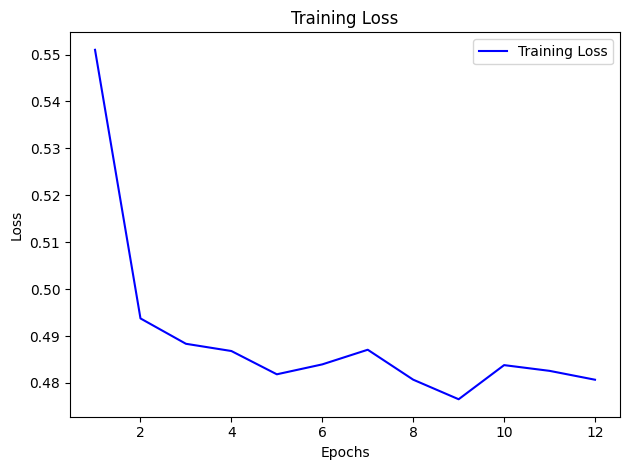

In [ ]:
import matplotlib.pyplot as plt

train_loss = autoencoder.metrics['train_loss']
epochs = range(1, len(train_loss) + 1)

# plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Reconstruction Tests:


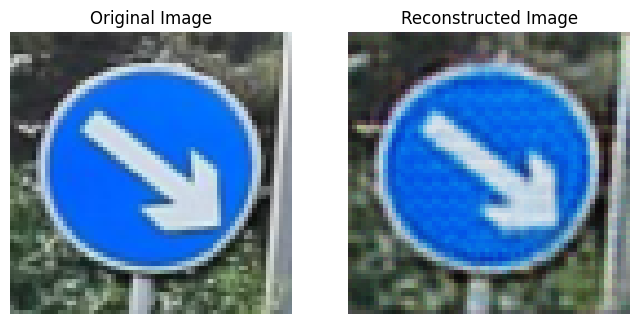

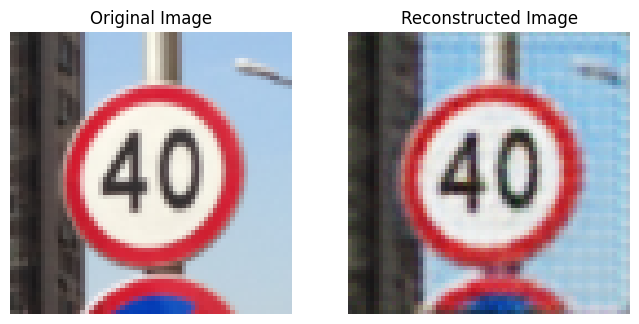

In [ ]:
from PIL import Image

def load_and_preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    return image

def reconstruct_image(image_path, transform):
    image = load_and_preprocess_image(image_path, transform)

    with torch.no_grad():
        reconstructions = autoencoder(image)

    original_img = image.squeeze(0).permute(1, 2, 0).numpy()
    reconstructed_img = reconstructions.squeeze(0).permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(reconstructed_img)
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    plt.show()



autoencoder.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

image_path = dataset_path / "Test"/ "026_1_0007_1_j.png"
reconstruct_image(image_path, transform)

image_path = dataset_path / "Test"/ "003_0001_j.png"
reconstruct_image(image_path, transform)